# Rotten Tomatoes Critic Reviews Sentiment Analysis

Aim of this Project is to train a model using the reviews of the critics and utilize the model to understand more about what people are saying about the movie.

Dataset: https://www.kaggle.com/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset

## Installing FastAi

To perfrom this analysis we will FastAi library.

In [1]:
! [ -e /content ] && pip install -Uqq fastai

     |████████████████████████████████| 186 kB 4.2 MB/s 
     |████████████████████████████████| 56 kB 4.1 MB/s 


In [2]:
import fastai
print(fastai.__version__)

2.5.2


## Import Data and Libraries

Data used in this notebook is taken from a public dataset off of Kaggle.
https://www.kaggle.com/stefanoleone992/rotten-tomatoes-movies-and-critic-reviews-dataset

It contains the data scraped from the publicly available website https://www.rottentomatoes.com as of 2020-10-31.


In [3]:
from fastai.text.all import *
import pandas as pd
from sklearn.model_selection import train_test_split,StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
df_og=pd.read_csv("rotten_tomatoes_critic_reviews.csv")

## Exploratory Data Analysis

In [168]:
# Few values from the dataset
df_og.head(3)

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology to contemporary American places and values. Anyone around 15 (give or take a couple of years) will thrill to the visual spectacle
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiffure of writhing snakes and stone-inducing hypnotic gaze is one of the highlights of this bewitching fantasy"
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,"With a top-notch cast and dazzling special effects, this will tide the teens over until the next Harry Potter instalment."


In [171]:
df_og.isnull().sum()

rotten_tomatoes_link         0
critic_name              18529
top_critic                   0
publisher_name               0
review_type                  0
review_score            305936
review_date                  0
review_content           65806
dtype: int64

We see that 65806 of our reviews are empty, we will go ahead and remove these from our further operations.

In [6]:
df=df_og.dropna(axis=0, subset=["review_content"])

In [170]:
df.isnull().sum()

rotten_tomatoes_link         0
critic_name              10013
top_critic                   0
publisher_name               0
review_type                  0
review_score            305502
review_date                  0
review_content               0
dtype: int64

The classes are heavily imbalanced as we can see from the count plot below. We will have to perform undersampling while training the classifier.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


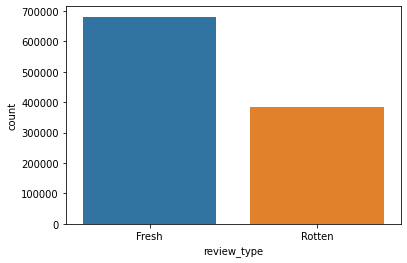

In [8]:
# View the distribution of review type
sns.countplot("review_type",data=df)

In [172]:
df.groupby("review_type").count()['review_content']

review_type
Fresh     681035
Rotten    383176
Name: review_content, dtype: int64

## Language Model Creation

Before we actually train the classifier for the sentiment analysis. We build a language model by fine-tuning our pre-trained model. This same pre-trained model will be used while fine-tuning our classifier, but we will use the encodings from this language model.

The Language model is to build the embeddings on which will help give our model context about the type of language (eg : reviews, news articles, reddit comments) it is being trained on.

No Data cleaning to balance out the categories is done on this language model data as we want to only get the understanding of the vocabulary and the embeddings. This also help in predicting the sentences from small phrases but that is a whole another application of this.

The training data is tokenized and serialized in the process of using the High Level API of Fast.Ai, it uses the tokenizer from the SpaCy library.


In [37]:
dls_lm=DataBlock(blocks=(TextBlock.from_df('review_content', is_lm=True)),
                 get_x=lambda r:r['text']).dataloaders(df, bs=128, seq_len=80)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [12]:
dls_lm.show_batch(max_n=3)

,text,text_
0,"xxbos xxmaj almost turns human misfortune into a costume parade . xxbos xxmaj without the benefit of historical perspective , xxmaj stone 's docudrama is empathetic , if oversimplified , having been rushed to completion to hit theaters before the xxmaj november election . xxbos xxmaj there 's something intoxicating about a film that manages to be both very violent and very pretty : it is unlike anything xxmaj i 've seen before , and in my book that is","xxmaj almost turns human misfortune into a costume parade . xxbos xxmaj without the benefit of historical perspective , xxmaj stone 's docudrama is empathetic , if oversimplified , having been rushed to completion to hit theaters before the xxmaj november election . xxbos xxmaj there 's something intoxicating about a film that manages to be both very violent and very pretty : it is unlike anything xxmaj i 've seen before , and in my book that is genius"
1,"a claustrophobic tale which turns from thriller to horror story by the end . xxmaj only if you ca n't suspend your disbelief will it fail to keep you watching . xxbos a one - joke comedy where the joke wears thin . xxbos xxmaj you 'll be delighted , if a bit breathless from laughing , to be along for the ride . xxbos xxmaj it 's an absolute tour - de - force for star xxmaj mary elizabeth","claustrophobic tale which turns from thriller to horror story by the end . xxmaj only if you ca n't suspend your disbelief will it fail to keep you watching . xxbos a one - joke comedy where the joke wears thin . xxbos xxmaj you 'll be delighted , if a bit breathless from laughing , to be along for the ride . xxbos xxmaj it 's an absolute tour - de - force for star xxmaj mary elizabeth -"
2,"not have the weight of ' great xxmaj art ' , but it crystallises youthful disaffection with the verve of the best and brightest pop culture . a sensation . xxbos a stunning look at how the right overcoat can turn a schlemiel into a respected leader . xxbos xxmaj bigelow 's extensive staging of the xxmaj may 1 , 2011 , raid is a prime example of virtuoso action filmmaking . xxbos xxmaj uno sale del cine y se","have the weight of ' great xxmaj art ' , but it crystallises youthful disaffection with the verve of the best and brightest pop culture . a sensation . xxbos a stunning look at how the right overcoat can turn a schlemiel into a respected leader . xxbos xxmaj bigelow 's extensive staging of the xxmaj may 1 , 2011 , raid is a prime example of virtuoso action filmmaking . xxbos xxmaj uno sale del cine y se da"


Language Model training is done here, what we want from this is the encoder that is resulting from it and the vocabulary from the data that we processed before.


In [55]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3,
    metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(valley=0.0020892962347716093)

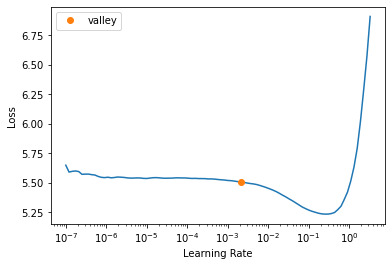

In [56]:
learn.lr_find()

In [57]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.992908,3.878147,0.346198,48.334564,30:49


In [58]:
learn.unfreeze()
learn.fit_one_cycle(3, lr_max=slice(1e-2, 2e-1))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.392606,4.327392,0.313075,75.746490,32:05
1,4.028554,3.970080,0.344457,52.988777,32:02
2,3.727988,3.698651,0.369958,40.392761,32:00


In [59]:
# Save the encoder for future use.
learn.save_encoder('rt_encoder')

## To train the Classifier

To train the classifier on this data we first need to balance it using a simple undersampling for now.

In [14]:
df.review_type.value_counts()

Fresh     681035
Rotten    383176
Name: review_type, dtype: int64

In [ ]:
# Sampling 'Fresh' Reviews equivalent to the number of 'Rotten' reviews
df[df['review_type']=='Fresh'].sample(5000)

In [ ]:
# Picking up all the Rotten reviews
df[df.review_type=='Rotten'].sample(5000)

Since the classes are imbalanced we perform undersampling.

In [142]:
# number of reviews to perform the classifier training on.
n_inputs=40000

df_under=pd.concat([df[df.review_type=='Fresh'].sample(n_inputs),df[df.review_type=='Rotten'].sample(n_inputs)])
df_under = df_under.sample(frac=1).reset_index(drop=True)

In [143]:
df_under.head(5)

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/serenity,Keith H. Brown,False,Eye for Film,Rotten,2.5/5,2008-10-18,In the end you are left with the feeling that Whedon works better on television than in the cinema.
1,m/squid_and_the_whale,Kimberley Jones,False,Austin Chronicle,Fresh,4/5,2005-12-06,"It's the sort of film that's bound to be labeled modest, but it packs a hefty emotional wallop."
2,m/the_gatekeepers_2012,Joe Morgenstern,True,Wall Street Journal,Fresh,NaN,2013-01-31,"The Israeli journalist Dror Moreh has hit a documentarian's trifecta with ""The Gatekeepers."""
3,m/the_hustle_2019,Brian Orndorf,False,Blu-ray.com,Rotten,D,2019-05-09,"Pure, uninspired recycling."
4,m/enigma_of_kaspar_hauser,Catherine Shoard,False,Observer (UK),Fresh,NaN,2013-07-07,"A compassionate, traumatic masterpiece, every frame amazing."


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


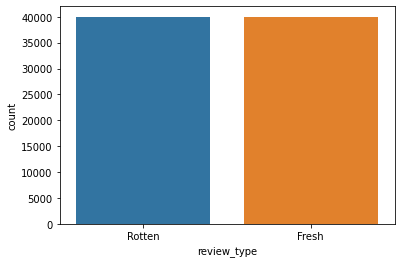

In [144]:
sns.countplot("review_type",data=df_under)

Since the Fastai classifier runs its own validation and we can just label the columns for the text and class name, we can just have the dataset split up easily using df.sample().

But just so that we are able to perform our own external testing on it we are going to split it into a train and test data.

In [145]:
# Splitting it using stratified fold
X=df_under["review_content"]
y=df_under["review_type"]

sss=StratifiedKFold(n_splits=4, random_state=None, shuffle=False)

for train_index,test_index in sss.split(X,y):
  print(train_index,"    ",test_index)


df_dict={'review':X.iloc[train_index], 'review_type':y.iloc[train_index]}
df_under_train=pd.DataFrame(data=df_dict)

df_dict={'review':X.iloc[test_index], 'review_type':y.iloc[test_index]}
df_under_test=pd.DataFrame(data=df_dict)

[19787 19788 19789 ... 79997 79998 79999]      [    0     1     2 ... 20224 20228 20230]
[    0     1     2 ... 79997 79998 79999]      [19787 19788 19789 ... 40337 40338 40340]
[    0     1     2 ... 79997 79998 79999]      [39662 39664 39665 ... 60015 60019 60020]
[    0     1     2 ... 60015 60019 60020]      [59972 59974 59976 ... 79997 79998 79999]


In [52]:
df_under_test.shape, df_under_train.shape

((10000, 2), (30000, 2))

Training the Classifier, we are using the AWD_LSTM model for this.

In [146]:
# In this step we are loading our data to be used for training.
dls_clas=DataBlock(blocks=(TextBlock.from_df('review', vocab=dls_lm.vocab),CategoryBlock),
                 get_x=lambda r:r['text'],get_y=lambda r:r['review_type']).dataloaders(df_under_train, bs=128, seq_len=80)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [147]:
# Show a small batch after the processing of the data.
dls_clas.show_batch(max_n=3)


,text,category
0,"xxbos xxmaj i 've never even seen the old xxmaj cary xxmaj grant version , and yet i know that even if it was the worst film of 1948 , it 's still 10 , xxrep 3 0 , xxrep 3 0 , xxrep 3 0 , xxrep 3 0 , xxrep 3 0 , xxrep 3 0 , xxrep 3 0 , xxrep 3 0 times better than xxmaj are xxmaj we xxmaj done xxmaj yet ?",Rotten
1,"xxbos xxmaj imagine this conversation : a phone call between actor xxmaj bob xxmaj de xxmaj niro and director xxmaj marty xxmaj scorsese . xxmaj bobby : xxmaj hello , xxmaj marty . xxmaj i 've been calling and texting , but you never answer . ( silence ) xxmaj bobby : xxmaj i 'm talking to you . xxmaj are you talkin ' to me ? xxmaj are you talkin ' to me ?",Rotten
2,"xxbos xxmaj there are nods to the 1931 xxmaj frankenstein as well as a shout - out of sorts to xxmaj mel xxmaj brooks ' 1974 xxmaj young xxmaj frankenstein ( although , sadly , no one exclaims , "" what knockers ! "" ) . xxmaj there 's also an extended cameo by xxmaj dawn of the xxmaj planet of the xxmaj apes ' scar - faced chimp xxmaj koba .",Rotten


In [148]:
# Training our learner
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=[accuracy,Precision(),Recall(),F1Score()]).to_fp16()

In [149]:
learn=learn.load_encoder('encoder_model_lm')

In [150]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.443753,0.399522,0.816250,0.789474,0.868850,0.827262,01:51


In [151]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.404439,0.360373,0.840583,0.821098,0.876090,0.847703,01:56


In [152]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.380307,0.350948,0.844500,0.826080,0.877736,0.851125,03:04
1,0.371826,0.347662,0.847833,0.840352,0.863584,0.851810,03:04


In [153]:
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.359925,0.343773,0.849167,0.838705,0.869343,0.853749,03:05
1,0.347868,0.342354,0.849417,0.827354,0.887938,0.856576,03:05


In [154]:
learn.save("model")

Path('models/model.pth')

##### See some outputs from the learner #####

In [155]:
learn.predict("Dreadful rich people make for brilliant TV, but it is rare to see their privileges and prejudices skewered with such relentless precision. White's characters can be monstrous, but they are so carefully wrought that they also feel painfully human.")

('Fresh', tensor(0), tensor([0.7575, 0.2425]))

In [156]:
learn.predict("Wow! That was painful. Waiting for something of substance to happen and it never came. Such a waste.")

('Rotten', tensor(1), tensor([0.0762, 0.9238]))

In [157]:
learn.predict("Watching Bartlett as Armond navigate their demands is often very, very funny; it's a sublime performance, playing against an ensemble of famous and instantly recognisable faces.")

('Fresh', tensor(0), tensor([0.9786, 0.0214]))

In [161]:
intrep_class=ClassificationInterpretation.from_learner(learn)

After training our model, the classification report shows us some interesting things.

1. We have an 85 % Accuracy for the binary classification.

2. We see only an 81% recall rate, which tells us that a lot of fresh reviews are being tagged as Rotten.

3. But when looking at the Precision it is nearly 89%. Which tells us that not a lot of Rotten reviews are being tagged as Fresh.

4. This difference most probably suggests, in our context, that the model is not able to catch the cases where language is not so straight forward. 

5. We will investigate it further by pulling up high loss results.

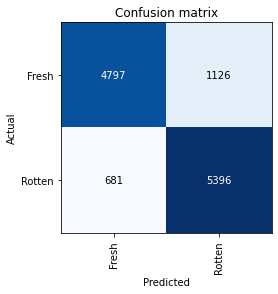

In [165]:
intrep_class.plot_confusion_matrix()

In [167]:
intrep_class.print_classification_report()

              precision    recall  f1-score   support

       Fresh       0.88      0.81      0.84      5923
      Rotten       0.83      0.89      0.86      6077

    accuracy                           0.85     12000
   macro avg       0.85      0.85      0.85     12000
weighted avg       0.85      0.85      0.85     12000



We can also see some of the top mistakes that our classifier made.

After reading a few of these reviews, a few thing to notice:

1. When the reviews are midway lets say at 60%, the drawbacks of the movies stated incline the probability of the result to Rotten, even though the score would suggest it to be Fresh.

2. Language used in a sarcastic way is often misunderstood.

In [173]:
intrep_class.plot_top_losses(20)

,input,target,predicted,probability,loss
0,"xxbos a fun , off - beat little horror film",Rotten,Fresh,0.9997147917747498,8.162394523620605
1,xxbos xxmaj too bad the dazzling ' eye candy ' technology was wasted on such a trivial pursuit .,Fresh,Rotten,0.9969306588172913,5.7862772941589355
2,xxbos xxmaj under - tens are unlikely to be the only ones wondering what 's going on ; the story is an over - brainstormed botch job .,Fresh,Rotten,0.9949396848678589,5.286323070526123
3,xxbos xxmaj it 's spectacular -- and spectacularly nasty .,Rotten,Fresh,0.9944342970848083,5.191128253936768
4,"xxbos xxmaj there 's a lot to like about xxmaj perks , but i just could n't shake the feeling that much like its main character , this movie is little more than an empty shell .",Fresh,Rotten,0.993320107460022,5.008655548095703
5,"xxbos xxmaj if you can overlook the stereotypes ( which i fear many xxmaj americans wo n't even notice as such ) , xxmaj traitor provides an entertaining evening at the movies .",Rotten,Fresh,0.9928231239318848,4.936890125274658
6,"xxbos xxmaj fantastic film for tweens , bearable film for the rest of us",Rotten,Fresh,0.9910666346549988,4.717957973480225
7,"xxbos xxmaj negligible budget and poor framing and crap in the film gate and shots that go in and out of focus and all , "" multiple xxmaj maniacs "" is a helluva movie .",Fresh,Rotten,0.9904775619506836,4.654099464416504
8,"xxbos xxmaj ice xxmaj cube is the best thing about the movie , but he has to work hard to overcome the inadequacies of this dreadful screenplay .",Fresh,Rotten,0.9899086952209473,4.596080303192139
9,"xxbos a little repetitive at times , but it 's an interesting way to review a period in history - through the music .",Rotten,Fresh,0.9895108342170715,4.557419776916504
